<a href="https://colab.research.google.com/github/ngtaylor/EE461P-Final-Project/blob/main/EE461P_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
!pip install catboost
!pip install binarytree==6.2.0
!pip install bracketeer==0.2.0
!pip install setuptools_scm==6.0.1
!pip install toml
!pip install shap 

In [182]:
#imports
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from bracketeer import build_bracket
from IPython.display import display, Image

In [183]:
#Import dataset
!wget https://github.com/ngtaylor/EE461P-Final-Project/blob/main/inputs/MDataFiles_Stage2.zip?raw=true
!wget https://github.com/ngtaylor/EE461P-Final-Project/blob/main/inputs/MDataFiles_Stage1.zip?raw=true

--2022-05-03 06:24:29--  https://github.com/ngtaylor/EE461P-Final-Project/blob/main/inputs/MDataFiles_Stage2.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ngtaylor/EE461P-Final-Project/raw/main/inputs/MDataFiles_Stage2.zip [following]
--2022-05-03 06:24:29--  https://github.com/ngtaylor/EE461P-Final-Project/raw/main/inputs/MDataFiles_Stage2.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ngtaylor/EE461P-Final-Project/main/inputs/MDataFiles_Stage2.zip [following]
--2022-05-03 06:24:29--  https://raw.githubusercontent.com/ngtaylor/EE461P-Final-Project/main/inputs/MDataFiles_Stage2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubu

In [184]:
#Extract data to '/inputs'
import zipfile
with zipfile.ZipFile('MDataFiles_Stage2.zip?raw=true', 'r') as zip_ref:
    zip_ref.extractall('inputs')
with zipfile.ZipFile('MDataFiles_Stage1.zip?raw=true', 'r') as zip_ref:
    zip_ref.extractall('inputs')

In [185]:
#Load data
venue = pd.read_csv('inputs/MDataFiles_Stage2/MGameCities.csv')
slot = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySlots.csv')
city = pd.read_csv('inputs/MDataFiles_Stage2/Cities.csv')
team = pd.read_csv('inputs/MDataFiles_Stage2/MTeams.csv')
season = pd.read_csv('inputs/MDataFiles_Stage2/MSeasons.csv')
seed = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySeeds.csv')
seed_copy = seed.copy()
round_slots = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySeedRoundSlots.csv')
slots = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySlots.csv')
ncaa1 = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneyDetailedResults.csv')
ncaa2 = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
ncaa2['Comp'] = 'ncaa'
ncaa2_copy = ncaa2.copy()
reg1 = pd.read_csv('inputs/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv')
reg2 = pd.read_csv('inputs/MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
reg2_copy = reg2.copy()
ordinals = pd.read_csv('inputs/MDataFiles_Stage2/MMasseyOrdinals_thruDay128.csv')
conf1 = pd.read_csv('inputs/MDataFiles_Stage2/Conferences.csv')
conf2 = pd.read_csv('inputs/MDataFiles_Stage2/MTeamConferences.csv')
ss = pd.read_csv('inputs/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
ss1 = pd.read_csv('inputs/MDataFiles_Stage1/MSampleSubmissionStage1.csv')

In [186]:
#Seed is data set for every MM from 1985-2022 Giving division and rank within
seed['region'] = seed.Seed.str[0]
seed['position'] = seed.Seed.str[1:3].astype('int')
seed.head()

,Season,Seed,TeamID,region,position
0,1985,W01,1207,W,1
1,1985,W02,1210,W,2
2,1985,W03,1228,W,3
3,1985,W04,1260,W,4
4,1985,W05,1374,W,5


In [187]:
#One hot encode region
oneHot = pd.get_dummies(seed.region, prefix='region')
seed = seed.join(oneHot)
seed.head()

,Season,Seed,TeamID,region,position,region_W,region_X,region_Y,region_Z
0,1985,W01,1207,W,1,1,0,0,0
1,1985,W02,1210,W,2,1,0,0,0
2,1985,W03,1228,W,3,1,0,0,0
3,1985,W04,1260,W,4,1,0,0,0
4,1985,W05,1374,W,5,1,0,0,0


In [188]:
#WTeam is a data set with 372 unique teams about their D1 start year and end year
WTeam = team.copy()
WTeam = WTeam.rename({'TeamID':'WTeamID'},axis=1)
WTeam = WTeam.rename({'TeamName':'WTeam'},axis=1)

In [189]:
#WTeam is a data set with 372 unique teams about their D1 start year and end year
LTeam = team.copy()
LTeam = LTeam.rename({'TeamID':'LTeamID'},axis=1)
LTeam = LTeam.rename({'TeamName':'LTeam'},axis=1)

In [190]:
#This makes a new data frame with Season and team IDs
new = pd.DataFrame()
new['Season'] = (ss['ID'].str[:4]).astype('int')
new['Comp'] = 'ncaa'
new['MinTeamID'] = (ss['ID'].str[5:9]).astype('int')
new['MaxTeamID'] = (ss['ID'].str[10:14]).astype('int')

In [191]:
for dfr in [seed,season, ncaa1, ncaa2, reg1, reg2]:
    dfr['Season'] = dfr['Season']+1
    dfr['Season'][dfr['Season']>2020]=dfr['Season']-1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [192]:
MinTeam = team.copy()
MinTeam = MinTeam.rename({'TeamID':'MinTeamID'},axis=1)
MinTeam = MinTeam.rename({'TeamName':'MinTeam'},axis=1)

In [193]:
MaxTeam = team.copy()
MaxTeam = MaxTeam.rename({'TeamID':'MaxTeamID'},axis=1)
MaxTeam = MaxTeam.rename({'TeamName':'MaxTeam'},axis=1)

In [194]:
#Set Max and Min team based on which team had the higher ID value
df = ncaa2
df = pd.merge(df,WTeam,on='WTeamID',how='left')
df = pd.merge(df,LTeam,on='LTeamID',how='left')
df['Handicap'] = df['WScore'] - df['LScore']
df['MinTeamID'] = df[['WTeamID','LTeamID']].min(axis=1)
df['MaxTeamID'] = df[['WTeamID','LTeamID']].max(axis=1)
df = df.append(new)

df['ID'] = df['Season'].astype(str) + '_' + df['MinTeamID'].astype(str) + '_' + df['MaxTeamID'].astype(str)
df['target'] = (df['WTeamID']<df['LTeamID']).astype('int')
df = pd.merge(df,MinTeam,on='MinTeamID',how='left')
df = pd.merge(df,MaxTeam,on='MaxTeamID',how='left')

Passing 'suffixes' which cause duplicate columns {'FirstD1Season_x', 'LastD1Season_x'} in the result is deprecated and will raise a MergeError in a future version.


In [195]:
#This just combines the year and ID into one string
df['MinTeamIDY'] = df['Season'].astype(str) + '_' + df['MinTeamID'].astype(str)
df['MaxTeamIDY'] = df['Season'].astype(str) + '_' + df['MaxTeamID'].astype(str)

seed['MaxTeamIDY'] = seed['Season'].astype(str) + '_' + seed['TeamID'].astype(str)
seed['MinTeamIDY'] = seed['Season'].astype(str) + '_' + seed['TeamID'].astype(str)

In [196]:
#Add teams aggregate mean ordinal rank and difference in rank between two teams
df_rank = ordinals.groupby(["TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
ranks_Max = df_rank.copy()
ranks_Min = df_rank.copy()
ranks_Max.columns = ['MaxTeamID','Max_rank_mean']
ranks_Min.columns = ['MinTeamID','Min_rank_mean']
df = pd.merge(df,ranks_Max,on = ["MaxTeamID"],how = "left")
df = pd.merge(df,ranks_Min,on = ["MinTeamID"],how = "left")
df["rankdiff"] = df["Max_rank_mean"] - df["Min_rank_mean"]
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Comp,WTeam,...,FirstD1Season_x,LastD1Season_x,MaxTeam,FirstD1Season_y,LastD1Season_y,MinTeamIDY,MaxTeamIDY,Max_rank_mean,Min_rank_mean,rankdiff
0,1986,136.0,1116.0,63.0,1234.0,54.0,N,0.0,ncaa,Arkansas,...,1985,2022,Iowa,1985,2022,1986_1116,1986_1234,64.197509,61.044654,3.152856
1,1986,136.0,1120.0,59.0,1345.0,58.0,N,0.0,ncaa,Auburn,...,1985,2022,Purdue,1985,2022,1986_1120,1986_1345,41.506060,96.834078,-55.328018
2,1986,136.0,1207.0,68.0,1250.0,43.0,N,0.0,ncaa,Georgetown,...,1985,2022,Lehigh,1985,2022,1986_1207,1986_1250,204.574156,58.107864,146.466292
3,1986,136.0,1229.0,58.0,1425.0,55.0,N,0.0,ncaa,Illinois St,...,1985,2022,USC,1985,2022,1986_1229,1986_1425,82.043060,140.447530,-58.404470
4,1986,136.0,1242.0,49.0,1325.0,38.0,N,0.0,ncaa,Kansas,...,1985,2022,Ohio,1985,2022,1986_1242,1986_1325,131.882451,9.807722,122.074729


In [197]:
df = pd.merge(df,seed[['MinTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MinTeamIDY',how='left')
df = pd.merge(df,seed[['MaxTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MaxTeamIDY',how='left')
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Comp,WTeam,...,position_x,region_W_x,region_X_x,region_Y_x,region_Z_x,position_y,region_W_y,region_X_y,region_Y_y,region_Z_y
0,1986,136.0,1116.0,63.0,1234.0,54.0,N,0.0,ncaa,Arkansas,...,9,0,1,0,0,8,0,1,0,0
1,1986,136.0,1120.0,59.0,1345.0,58.0,N,0.0,ncaa,Auburn,...,11,0,0,0,1,6,0,0,0,1
2,1986,136.0,1207.0,68.0,1250.0,43.0,N,0.0,ncaa,Georgetown,...,1,1,0,0,0,16,1,0,0,0
3,1986,136.0,1229.0,58.0,1425.0,55.0,N,0.0,ncaa,Illinois St,...,9,0,0,1,0,8,0,0,1,0
4,1986,136.0,1242.0,49.0,1325.0,38.0,N,0.0,ncaa,Kansas,...,3,0,0,0,1,14,0,0,0,1


In [198]:
pred_yr = 2022
history = df[df.Season<pred_yr]
history1 = history[['Season','MinTeamID','MaxTeamID','target']].rename({'MinTeamID':'TeamID','MaxTeamID':'OpponentID'},axis=1)
history2 = history[['Season','MaxTeamID','MinTeamID','target']].rename({'MaxTeamID':'TeamID','MinTeamID':'OpponentID'},axis=1)
history2.target = 1 - history2.target 
history = history1.append(history2)

In [199]:
#Create stats per season
yr_stats = history.copy()
yr_stats['win_stats'] = yr_stats.groupby(['TeamID','Season'])['target'].transform('mean')
yr_stats['played'] = yr_stats.groupby(['TeamID','Season'])['target'].transform('count')
yr_stats.drop(['OpponentID','target'],axis=1,inplace=True)
yr_stats = yr_stats.sort_values(['Season','win_stats'])
yr_stats = yr_stats.drop_duplicates(['TeamID','Season'])

yr_stats.Season = yr_stats.Season + 1
yr_stats['MaxTeamIDY'] = yr_stats['Season'].astype(str) + '_' + yr_stats['TeamID'].astype(str)
yr_stats['MinTeamIDY'] = yr_stats['Season'].astype(str) + '_' + yr_stats['TeamID'].astype(str)

yr_stats.describe()

,Season,TeamID,win_stats,played
count,2353.000000,2353.000000,2353.000000,2353.000000
mean,2004.726307,1291.514662,0.311482,1.969401
std,10.422123,103.296346,0.321486,1.279050
min,1987.000000,1101.000000,0.000000,1.000000
25%,1996.000000,1208.000000,0.000000,1.000000
50%,2005.000000,1287.000000,0.500000,2.000000
75%,2014.000000,1387.000000,0.500000,2.000000
max,2022.000000,1463.000000,1.000000,6.000000


In [200]:
# Add year stats for year of prediction to our dataframe
df = pd.merge(df,yr_stats[['MinTeamIDY','win_stats','played']],on='MinTeamIDY',how='left')
df = pd.merge(df,yr_stats[['MaxTeamIDY','win_stats','played']],on='MaxTeamIDY',how='left')

In [201]:
#Replace missing values: replace missing win stat with 0.5 and missing played with 2
df['win_stats_x'] = df['win_stats_x'].fillna(0.5)
df['win_stats_y'] = df['win_stats_y'].fillna(0.5)

df['played_x'] = df['played_x'].fillna(2)
df['played_y'] = df['played_y'].fillna(2)

In [202]:
#Categorical columns and numerical columns only using features that matter
cat_cols = ['MinTeamID','MaxTeamID','region_W_x','region_X_x','region_Y_x','region_Z_x','region_W_y','region_X_y','region_Y_y','region_Z_y',] 
num_cols = [
    'position_x','position_y',
    'win_stats_x','played_x','win_stats_y','played_y',
    'Max_rank_mean', 'Min_rank_mean', 'rankdiff'
]
cols = num_cols+cat_cols

In [203]:
#Create training data dataframe for the model
tdf = df[df.Season==pred_yr]
tdf = tdf[tdf['Comp']=='ncaa']
reg_pred_yr = df[(df.Season==pred_yr)&(df.Comp=='reg')]

train = df[df.Season<pred_yr].append(reg_pred_yr)

tdf['ID']

2317    2022_1103_1104
2318    2022_1103_1112
2319    2022_1103_1116
2320    2022_1103_1120
2321    2022_1103_1124
             ...      
4590    2022_1458_1461
4591    2022_1458_1463
4592    2022_1460_1461
4593    2022_1460_1463
4594    2022_1461_1463
Name: ID, Length: 2278, dtype: object

In [204]:
#Train MLP Classifier model
mlp_class = MLPClassifier()
mlp_class.fit(train[cols], train.target, )

tdf['Pred'] = mlp_class.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
mlp_output = ss.copy()
mlp_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
mlp_output.to_csv('mlp_pred.csv',index=False)
mlp_output

,ID,Pred
0,2022_1103_1104,0.035449
1,2022_1103_1112,0.021898
2,2022_1103_1116,0.027487
3,2022_1103_1120,0.030187
4,2022_1103_1124,0.018161
...,...,...
2273,2022_1458_1461,0.733501
2274,2022_1458_1463,0.804600
2275,2022_1460_1461,0.026011
2276,2022_1460_1463,0.031615


In [205]:
#Cat Boost classifier model (deals with missing values internally)
cat = CatBoostClassifier(n_estimators=50,silent=True,objective='Logloss',
                          cat_features=cat_cols)
cat.fit(train[cols],train.target)
tdf['Pred'] = cat.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
cat_output = ss.copy()
cat_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
cat_output.to_csv('cat_pred.csv',index=False)
cat_output

,ID,Pred
0,2022_1103_1104,0.257703
1,2022_1103_1112,0.102981
2,2022_1103_1116,0.248746
3,2022_1103_1120,0.183877
4,2022_1103_1124,0.142724
...,...,...
2273,2022_1458_1461,0.869554
2274,2022_1458_1463,0.889429
2275,2022_1460_1461,0.260657
2276,2022_1460_1463,0.439650


Text(0.5, 0, 'CatBoost Feature Importance')

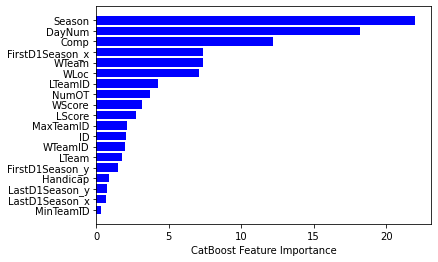

In [206]:
sorted_feature_importance = cat.feature_importances_.argsort()
plt.barh(train.columns[sorted_feature_importance], 
        cat.feature_importances_[sorted_feature_importance], 
        color='blue')
plt.xlabel("CatBoost Feature Importance")

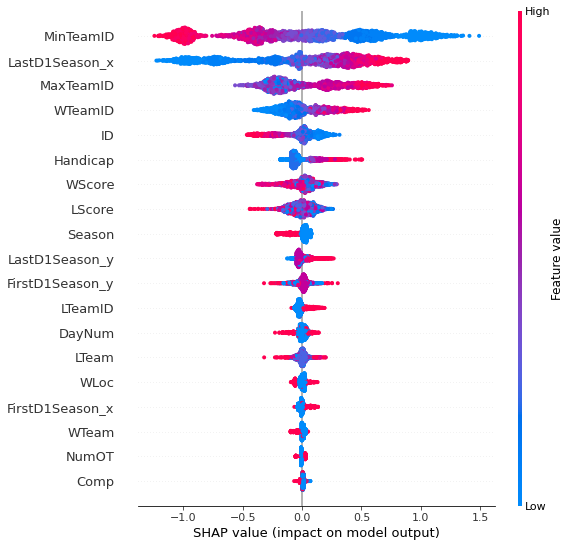

In [207]:
import shap
explainer = shap.TreeExplainer(cat)

tdf['Pred'] = cat.predict_proba(tdf[cols])[:,1]

shap_values = explainer.shap_values(train[cols])
shap.summary_plot(shap_values, train[cols], feature_names = train.columns[sorted_feature_importance])

In [208]:
#Train Logistic Regression model
reg = LogisticRegression(max_iter=1000)
reg.fit(train[cols], train.target)

tdf['Pred'] = reg.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
reg_output = ss.copy()
reg_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
reg_output.to_csv('reg_pred.csv',index=False)
reg_output

,ID,Pred
0,2022_1103_1104,0.241033
1,2022_1103_1112,0.116380
2,2022_1103_1116,0.203342
3,2022_1103_1120,0.189343
4,2022_1103_1124,0.150624
...,...,...
2273,2022_1458_1461,0.830148
2274,2022_1458_1463,0.867747
2275,2022_1460_1461,0.324000
2276,2022_1460_1463,0.391515


In [209]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [210]:
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import model_selection

#Train Random Forest model
rando_forest = ensemble.RandomForestClassifier()
params = {'n_estimators': [50, 75, 100, 125, 150], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
gs = model_selection.GridSearchCV(rando_forest, params)
gs_fit = gs.fit(train[cols], train.target)
gs_fit.best_params_

rando_forest_optimal = ensemble.RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=50)
rando_forest_optimal_fit = rando_forest_optimal.fit(train[cols], train.target)

tdf['Pred'] = rando_forest_optimal_fit.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
rf_output = ss.copy()
rf_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
rf_output.to_csv('rf_pred.csv',index=False)
rf_output

,ID,Pred
0,2022_1103_1104,0.12
1,2022_1103_1112,0.14
2,2022_1103_1116,0.06
3,2022_1103_1120,0.14
4,2022_1103_1124,0.12
...,...,...
2273,2022_1458_1461,0.82
2274,2022_1458_1463,0.88
2275,2022_1460_1461,0.32
2276,2022_1460_1463,0.46


In [211]:
import xgboost as xgb

#Train basic xgboost model
xgb_model = xgb.XGBClassifier()

xgb_model.fit(train[cols], train.target, verbose=False)

tdf['Pred'] = xgb_model.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
xgb_output = ss.copy()
xgb_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
xgb_output.to_csv('xgb_pred.csv',index=False)
xgb_output

,ID,Pred
0,2022_1103_1104,0.123286
1,2022_1103_1112,0.051812
2,2022_1103_1116,0.117637
3,2022_1103_1120,0.097301
4,2022_1103_1124,0.148055
...,...,...
2273,2022_1458_1461,0.909546
2274,2022_1458_1463,0.929540
2275,2022_1460_1461,0.251645
2276,2022_1460_1463,0.459619


In [212]:
#Then we would apply these results to the actual tournament results, and use different models to do so
#A bracket structure needs to be simulated using the TourneyRoundSlots, TourneySeeds, and TourneySlots csvs
#The starting seeds for 2022 are given so we just need to manually compare to the actual results once we have made our own bracket



In [213]:
#create bracket
def display_bracket(file_name, yr):
  inp = 'inputs/MDataFiles_Stage2/'

  b = build_bracket(
  outputPath='output_current.png',
  teamsPath=inp+'MTeams.csv',
  seedsPath=inp+'MNCAATourneySeeds.csv',
  submissionPath=file_name,
  slotsPath=inp+'MNCAATourneySlots.csv',
  year=yr
  )

  display(Image(filename='./output_current.png'))

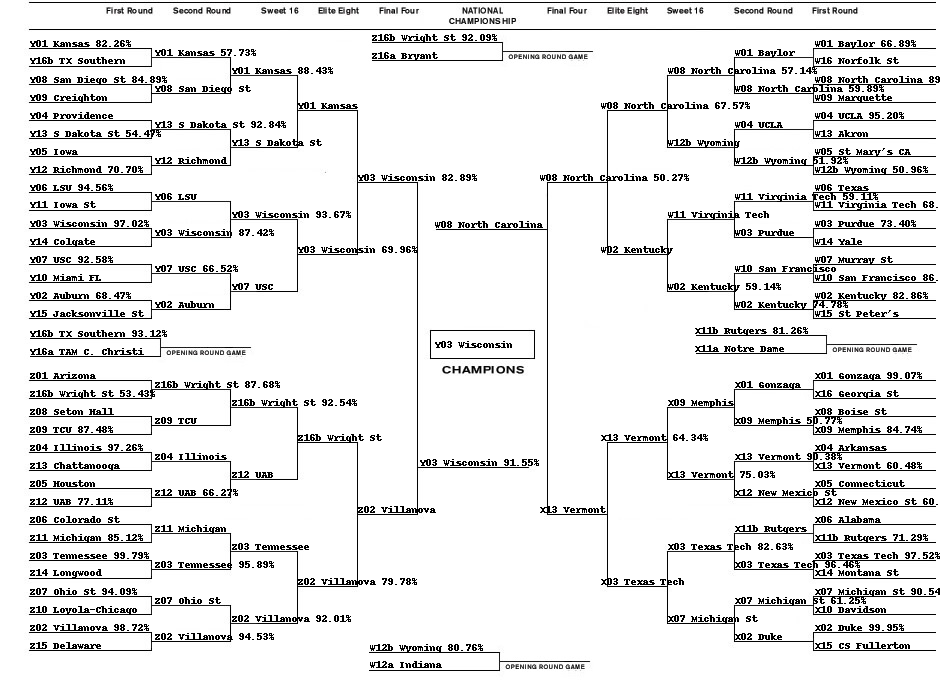

In [214]:
display_bracket('mlp_pred.csv', 2022)

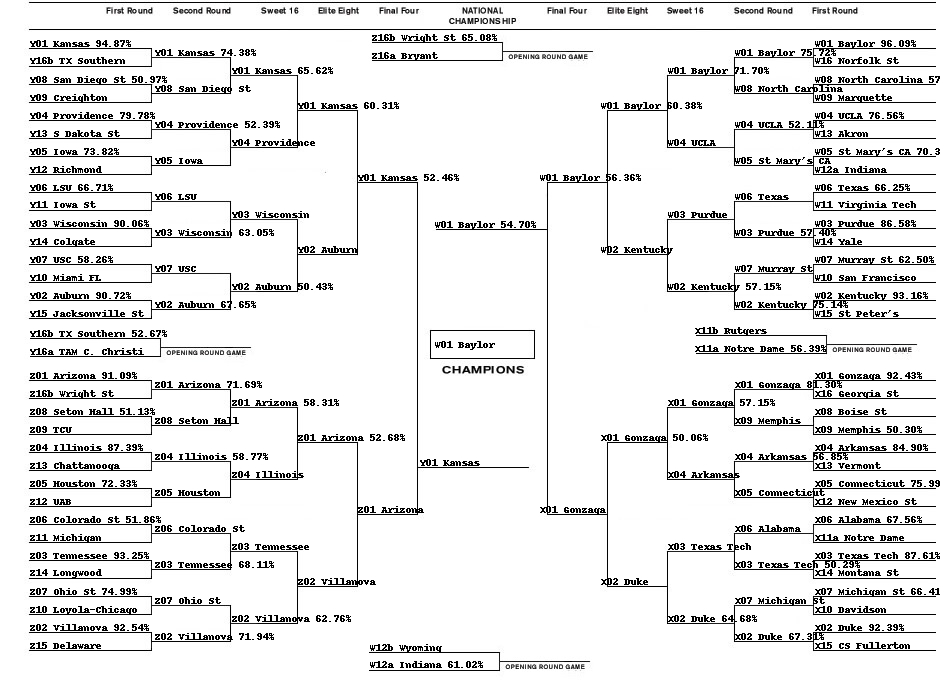

In [215]:
display_bracket('reg_pred.csv', 2022)

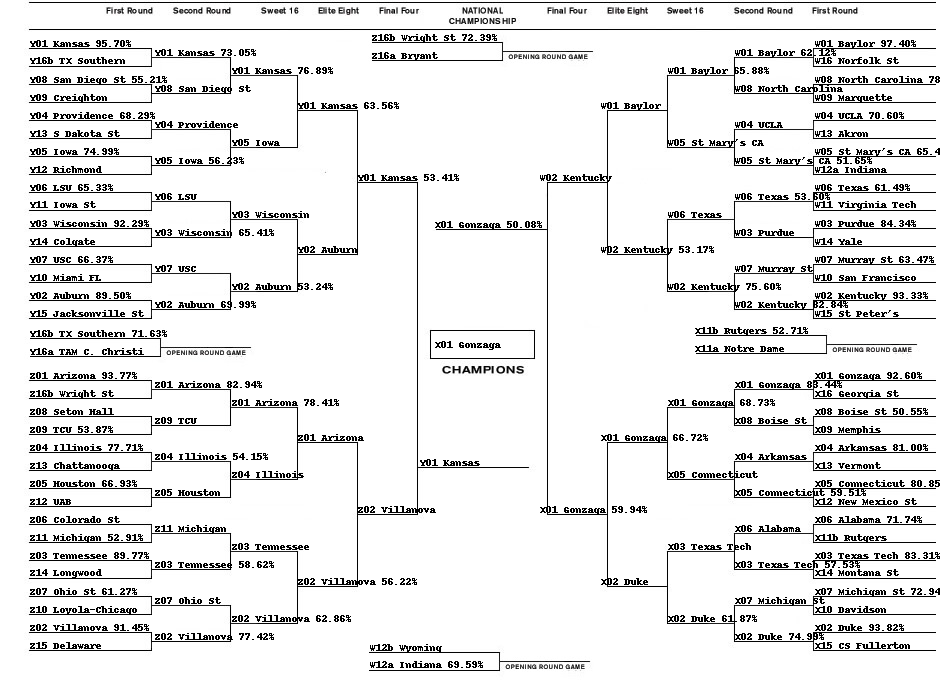

In [216]:
display_bracket('cat_pred.csv', 2022)

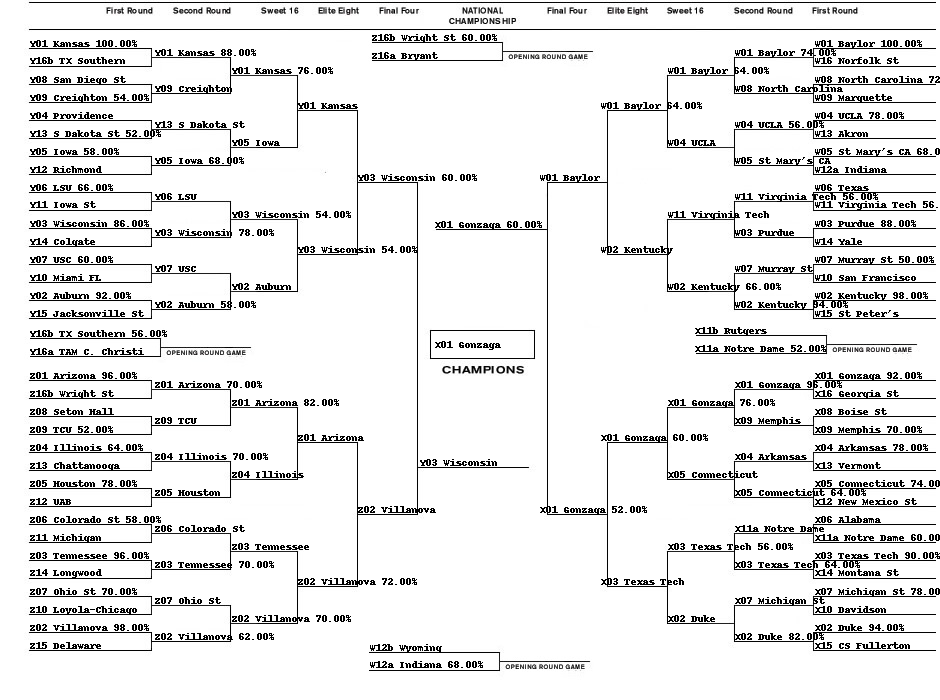

In [217]:
display_bracket('rf_pred.csv', 2022)

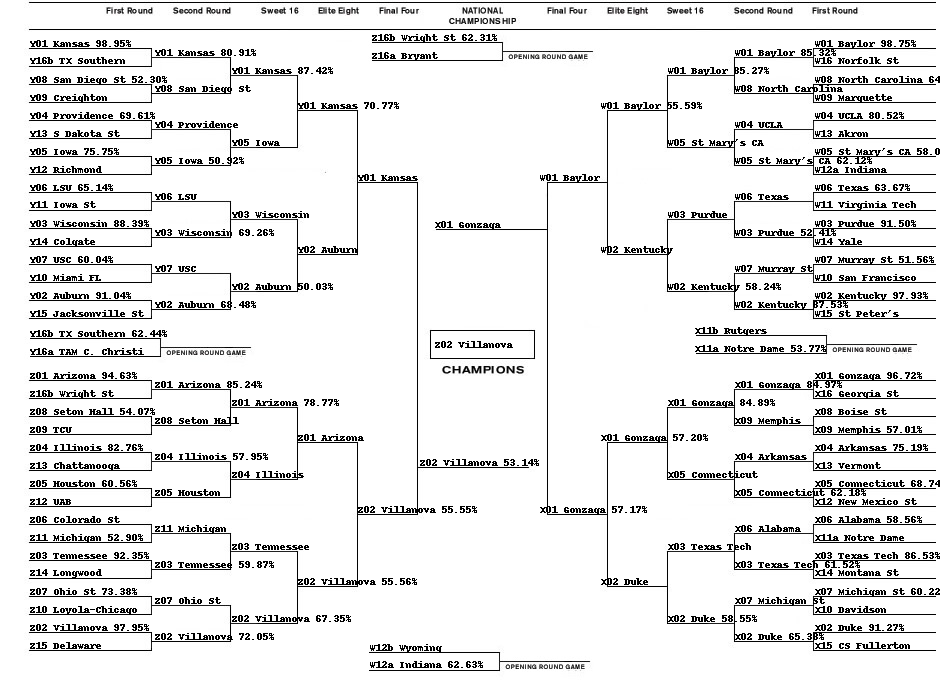

In [218]:
display_bracket('xgb_pred.csv', 2022)

In [219]:
import random
#This function will create predictions for a given year
def make_prediction(year):
  seeds = seed_copy.copy()

  #Seed is data set for every MM from 1985-2022 Giving division and rank within
  seeds['region'] = seeds.Seed.str[0]
  seeds['position'] = seeds.Seed.str[1:3].astype('int')

  #One hot encode region
  oneHot_ = pd.get_dummies(seeds.region, prefix='region')
  seeds = seeds.join(oneHot_)

  #WTeam is a data set with 372 unique teams about their D1 start year and end year
  WTeam_ = team.copy()
  WTeam_ = WTeam_.rename({'TeamID':'WTeamID'},axis=1)
  WTeam_ = WTeam_.rename({'TeamName':'WTeam'},axis=1)

  #WTeam is a data set with 372 unique teams about their D1 start year and end year
  LTeam_ = team.copy()
  LTeam_ = LTeam_.rename({'TeamID':'LTeamID'},axis=1)
  LTeam_ = LTeam_.rename({'TeamName':'LTeam'},axis=1)

  #This makes a new data frame with Season and team IDs
  new_ = pd.DataFrame()
  new_['Season'] = (ss1['ID'].str[:4]).astype('int')
  new_['Comp'] = 'ncaa'
  new_['MinTeamID'] = (ss1['ID'].str[5:9]).astype('int')
  new_['MaxTeamID'] = (ss1['ID'].str[10:14]).astype('int')
  new_ = new_[new_.Season==year]

  for dfr in [seeds]:
      dfr['Season'] = dfr['Season']+1
      dfr['Season'][dfr['Season']>2020]=dfr['Season']-1

  MinTeam_ = team.copy()
  MinTeam_ = MinTeam_.rename({'TeamID':'MinTeamID'},axis=1)
  MinTeam_ = MinTeam_.rename({'TeamName':'MinTeam'},axis=1)

  MaxTeam_ = team.copy()
  MaxTeam_ = MaxTeam_.rename({'TeamID':'MaxTeamID'},axis=1)
  MaxTeam_ = MaxTeam_.rename({'TeamName':'MaxTeam'},axis=1)

  #Set Max and Min team based on which team had the higher ID value
  data = ncaa2_copy.copy()
  data = pd.merge(data,WTeam_,on='WTeamID',how='left')
  data = pd.merge(data,LTeam_,on='LTeamID',how='left')
  data['Handicap'] = data['WScore'] - data['LScore']
  data['MinTeamID'] = data[['WTeamID','LTeamID']].min(axis=1)
  data['MaxTeamID'] = data[['WTeamID','LTeamID']].max(axis=1)
  data = data[data.Season<year]
  data = data.append(new_)
  data.fillna(0)

  data['ID'] = data['Season'].astype(str) + '_' + data['MinTeamID'].astype(str) + '_' + data['MaxTeamID'].astype(str)
  data['target'] = (data['WTeamID']<data['LTeamID']).astype('int')
  data = pd.merge(data,MinTeam_,on='MinTeamID',how='left')
  data = pd.merge(data,MaxTeam_,on='MaxTeamID',how='left')

  #This just combines the year and ID into one string
  data['MinTeamIDY'] = data['Season'].astype(str) + '_' + data['MinTeamID'].astype(str)
  data['MaxTeamIDY'] = data['Season'].astype(str) + '_' + data['MaxTeamID'].astype(str)

  seeds['MaxTeamIDY'] = seeds['Season'].astype(str) + '_' + seeds['TeamID'].astype(str)
  seeds['MinTeamIDY'] = seeds['Season'].astype(str) + '_' + seeds['TeamID'].astype(str)

  #Add teams aggregate mean ordinal rank and difference in rank between two teams
  data_rank = ordinals.groupby(["TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
  rank_Max = data_rank.copy()
  rank_Min = data_rank.copy()
  rank_Max.columns = ['MaxTeamID','Max_rank_mean']
  rank_Min.columns = ['MinTeamID','Min_rank_mean']
  data = pd.merge(data,rank_Max,on = ["MaxTeamID"],how = "left")
  data = pd.merge(data,rank_Min,on = ["MinTeamID"],how = "left")
  data["rankdiff"] = data["Max_rank_mean"] - data["Min_rank_mean"]

  data = pd.merge(data,seeds[['MinTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MinTeamIDY',how='left')
  data = pd.merge(data,seeds[['MaxTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MaxTeamIDY',how='left')

  yr = year
  hist = data[data.Season<yr]
  hist1 = hist[['Season','MinTeamID','MaxTeamID','target']].rename({'MinTeamID':'TeamID','MaxTeamID':'OpponentID'},axis=1)
  hist2 = hist[['Season','MaxTeamID','MinTeamID','target']].rename({'MaxTeamID':'TeamID','MinTeamID':'OpponentID'},axis=1)
  hist2.target = 1 - hist2.target 
  hist = hist1.append(hist2)

  #Create stats per season
  yr_stat = hist.copy()
  yr_stat['win_stats'] = yr_stat.groupby(['TeamID','Season'])['target'].transform('mean')
  yr_stat['played'] = yr_stat.groupby(['TeamID','Season'])['target'].transform('count')
  yr_stat.drop(['OpponentID','target'],axis=1,inplace=True)
  yr_stat = yr_stat.sort_values(['Season','win_stats'])
  yr_stat = yr_stat.drop_duplicates(['TeamID','Season'])

  yr_stat.Season = yr_stat.Season + 1
  yr_stat['MaxTeamIDY'] = yr_stat['Season'].astype(str) + '_' + yr_stat['TeamID'].astype(str)
  yr_stat['MinTeamIDY'] = yr_stat['Season'].astype(str) + '_' + yr_stat['TeamID'].astype(str)

  # Add year stats for year of prediction to our dataframe
  data = pd.merge(data,yr_stat[['MinTeamIDY','win_stats','played']],on='MinTeamIDY',how='left')
  data = pd.merge(data,yr_stat[['MaxTeamIDY','win_stats','played']],on='MaxTeamIDY',how='left')

  #Replace missing values: replace missing win stat with 0.5 and missing played with 2
  data['win_stats_x'] = data['win_stats_x'].fillna(0.5)
  data['win_stats_y'] = data['win_stats_y'].fillna(0.5)

  data['played_x'] = data['played_x'].fillna(2)
  data['played_y'] = data['played_y'].fillna(2)

  data.fillna(0)

  #Categorical columns and numerical columns only using features that matter
  cat_cols = ['MinTeamID','MaxTeamID','region_W_x','region_X_x','region_Y_x','region_Z_x','region_W_y','region_X_y','region_Y_y','region_Z_y',] 
  num_cols = [
      'position_x','position_y',
      'win_stats_x','played_x','win_stats_y','played_y',
      'Max_rank_mean', 'Min_rank_mean', 'rankdiff'
  ]
  cols = num_cols+cat_cols

  #Create training data dataframe for the model
  data = data.drop(['LastD1Season_x', 'LastD1Season_y', 'FirstD1Season_x', 'FirstD1Season_y'], axis=1)
  data.to_csv('data.csv', index=False)
  tdf_ = data[data.Season==yr]
  tdf_ = tdf_[tdf_['Comp']=='ncaa']
  reg_pred = data[(data.Season==yr)&(data.Comp=='reg')]

  train_ = data[data.Season<yr].append(reg_pred)

  #Cat Boost classifier model (deals with missing values internally)
  cat_ = CatBoostClassifier(n_estimators=50,silent=True,objective='Logloss',
                            cat_features=cat_cols)
  cat_.fit(train_[cols],train_.target)
  tdf_['Pred'] = cat_.predict_proba(tdf_[cols])[:,1]

  #Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
  cat_output_ = ss1.copy()
  if(year == 2016):
    cat_output_ = cat_output_.iloc[0:2278]
  if(year == 2017):
    cat_output_ = cat_output_.iloc[2278:4556]
  if(year == 2018):
    cat_output_ = cat_output_.iloc[4556:6834]
  if(year == 2019):
    cat_output_ = cat_output_.iloc[6834:9112]
  if(year == 2021):
    cat_output_ = cat_output_.iloc[9112:11390]

  cat_output_ = pd.merge(cat_output_['ID'],tdf_[['ID','Pred']],on='ID',how='left')
  #cat_output_ =  cat_output_[cat_output_.ID.str[0:3]==str(year)]
  year_string = str(year)
  file_name = year_string + '_pred.csv'
  cat_output_.to_csv(file_name ,index=False)
 
def rando_prediction(year):
  pred = ss1.copy()
  i = 0
  for value in pred['Pred']:
    i = i + 1
  new_Pred = np.random.uniform(0, 1, i)  
  pred['Pred'] = new_Pred

  pred['Season'] = (ss1['ID'].str[:4]).astype('int')
  pred = pred[pred.Season==year]
  pred =  pred.drop('Season', axis=1)
  year_string = str(year)
  file_name = year_string + '_pred.csv'
  pred.to_csv(file_name ,index=False)
  

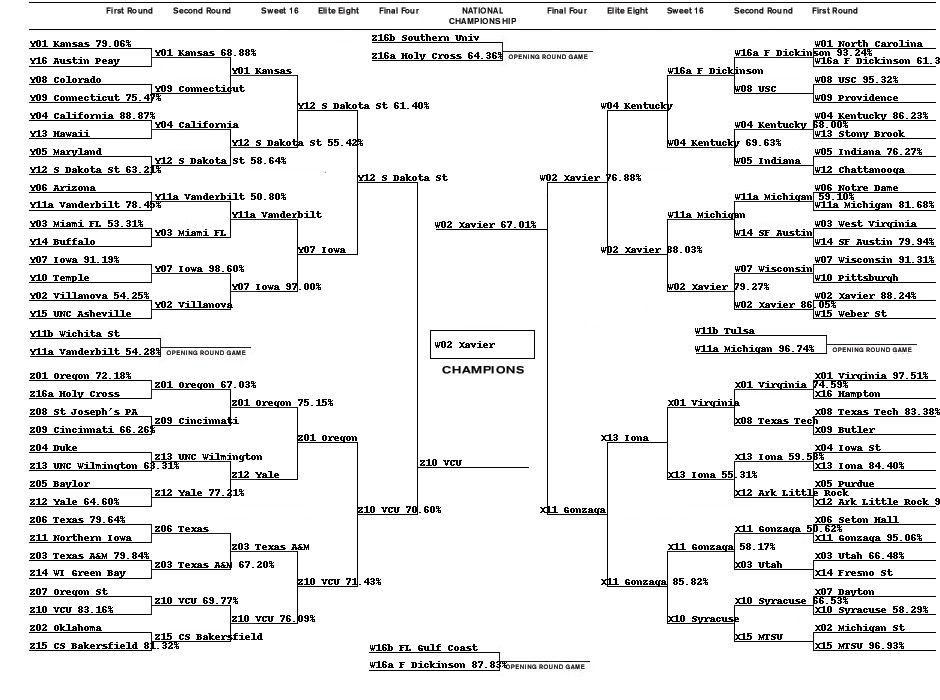

In [220]:
#2016 bracket
rando_prediction(2016)
display_bracket('2016_pred.csv', 2016)

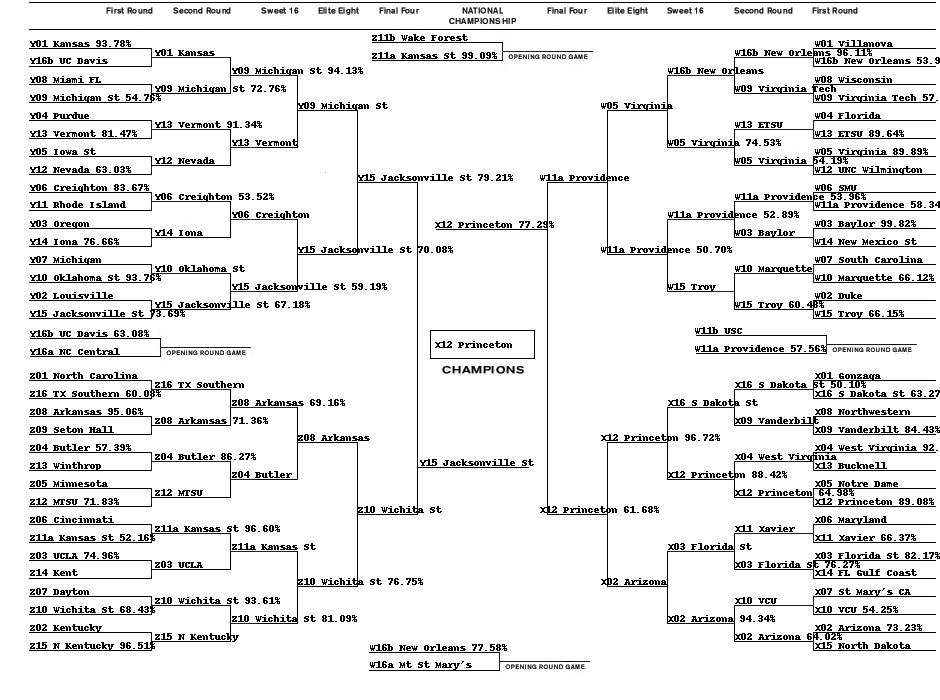

In [221]:
#2017 bracket
rando_prediction(2017)
display_bracket('2017_pred.csv', 2017)

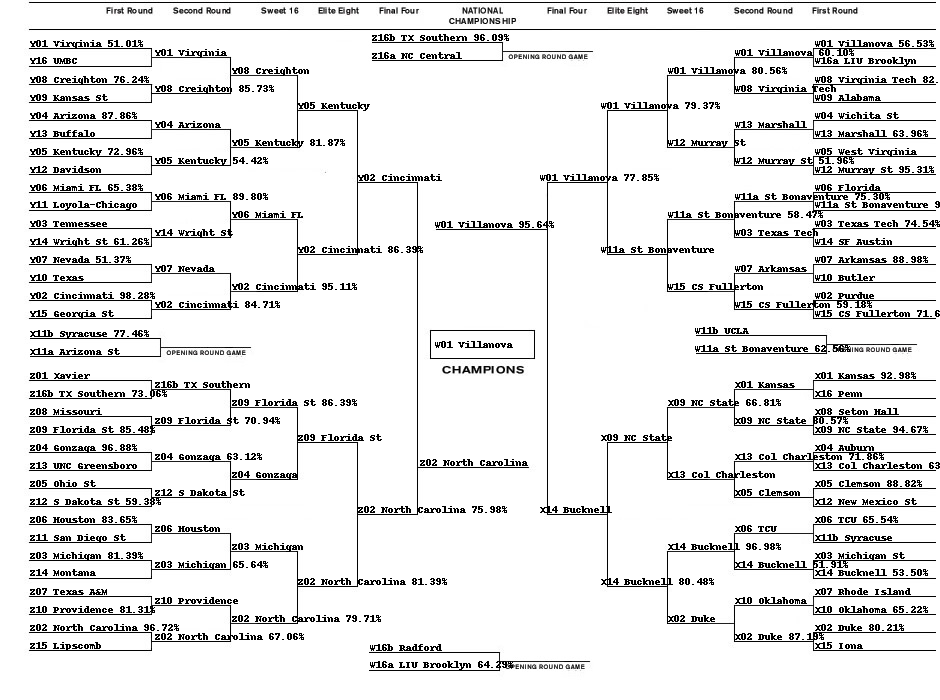

In [222]:
#2018 bracket
rando_prediction(2018)
display_bracket('2018_pred.csv', 2018)

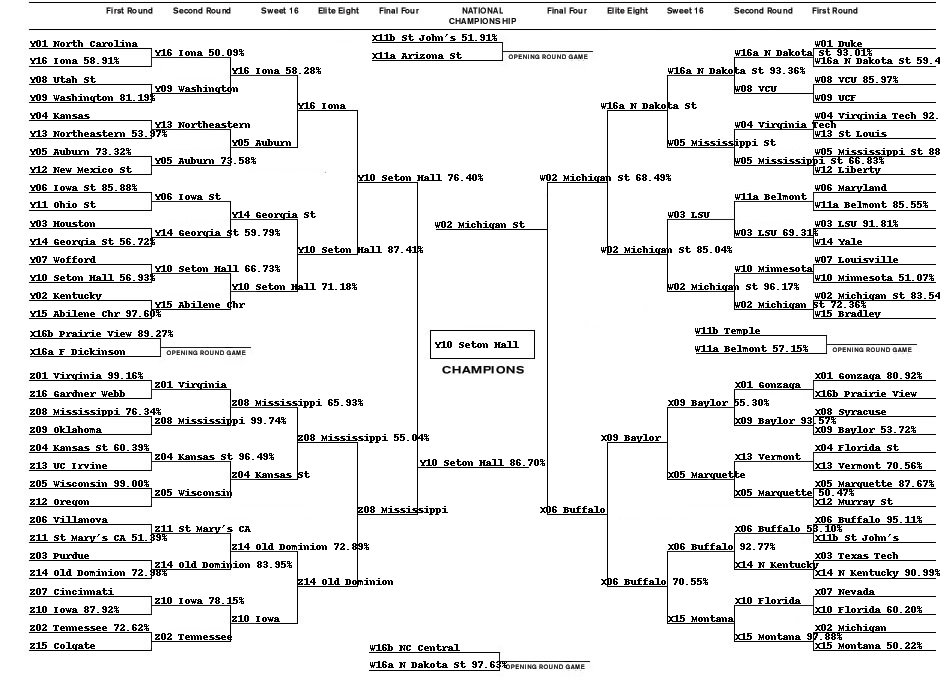

In [223]:
#2019 bracket
rando_prediction(2019)
display_bracket('2019_pred.csv', 2019)

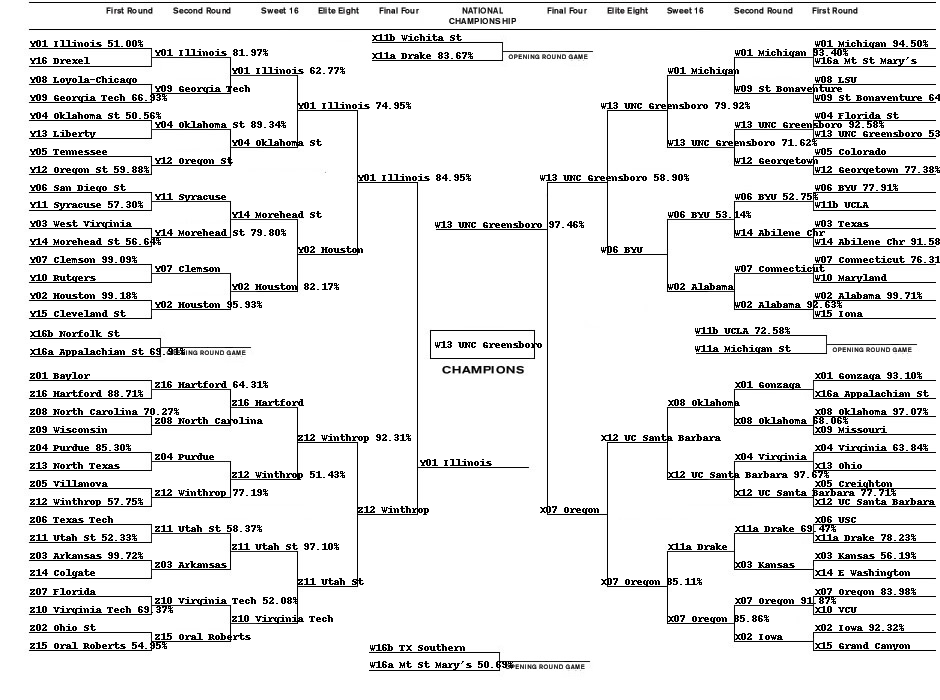

In [224]:
#2021 bracket
rando_prediction(2021)
display_bracket('2021_pred.csv', 2021)

In [225]:
import numpy as np
import pandas as pd
import seaborn as sns

def create_heatmap(submission, season):
    preds = pd.read_csv(submission)
    seeds = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySeeds.csv')
    seeds = seeds[seeds.Season == season]
    team_id = seeds.TeamID
    team_id.reset_index(drop=True, inplace=True)
    map = np.full((68,68), np.nan)
    for row in preds.itertuples():
        teams = row.ID.split('_')[1:]
        val = row.Pred
        map[team_id[team_id == int(teams[0])].index[0], team_id[team_id == int(teams[1])].index[0]] = val
        map[team_id[team_id == int(teams[1])].index[0], team_id[team_id == int(teams[0])].index[0]] = 1 - val
    return map, team_id
    

In [226]:
import matplotlib.pyplot as plt

def plot_heatmap(submission, season):
  map, team_id = create_heatmap(submission, season)

  teams = pd.read_csv('inputs/MDataFiles_Stage2/MTeams.csv')
  team_id_verbose = []
  for elem in team_id:
      team_id_verbose.append(str(teams[teams.TeamID == elem]['TeamName'].values[0]))


  fig, ax = plt.subplots(figsize=(18,15))
  sns.heatmap(map, cmap=sns.color_palette("coolwarm", as_cmap=True), vmin=0, vmax=1, xticklabels=team_id_verbose, yticklabels=team_id_verbose)

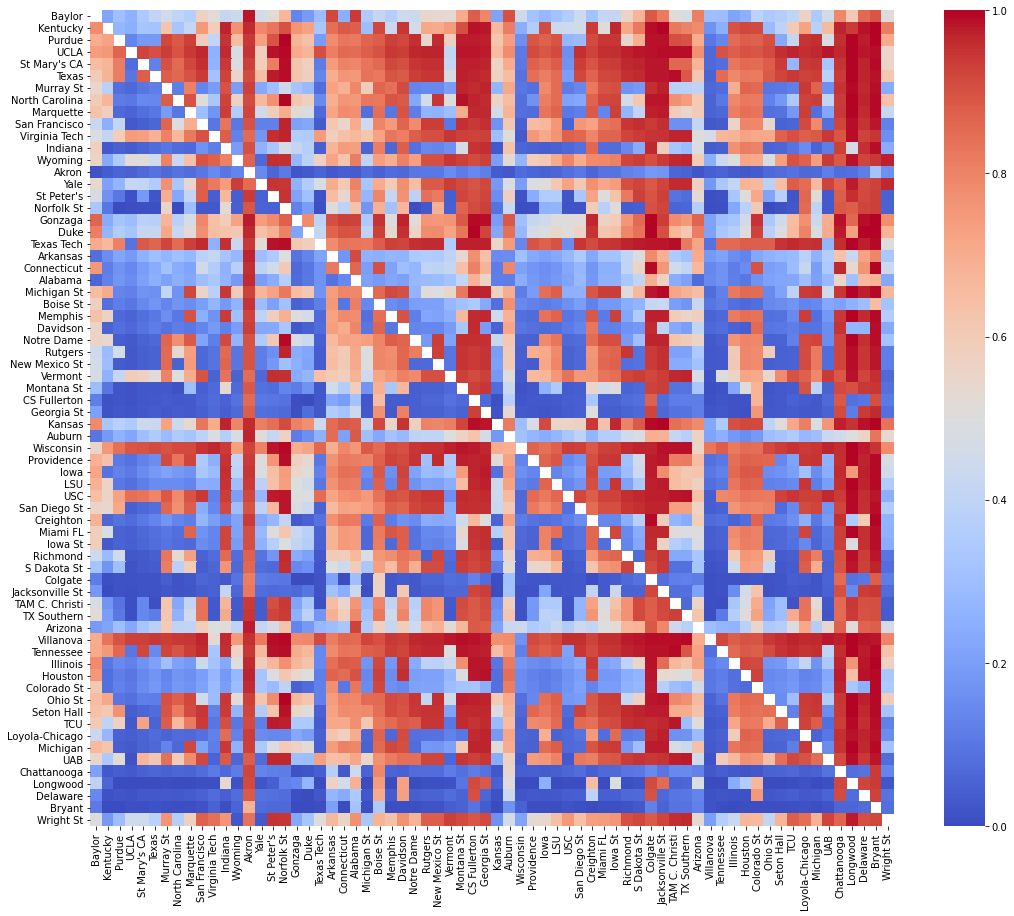

In [227]:
plot_heatmap('mlp_pred.csv', 2022)

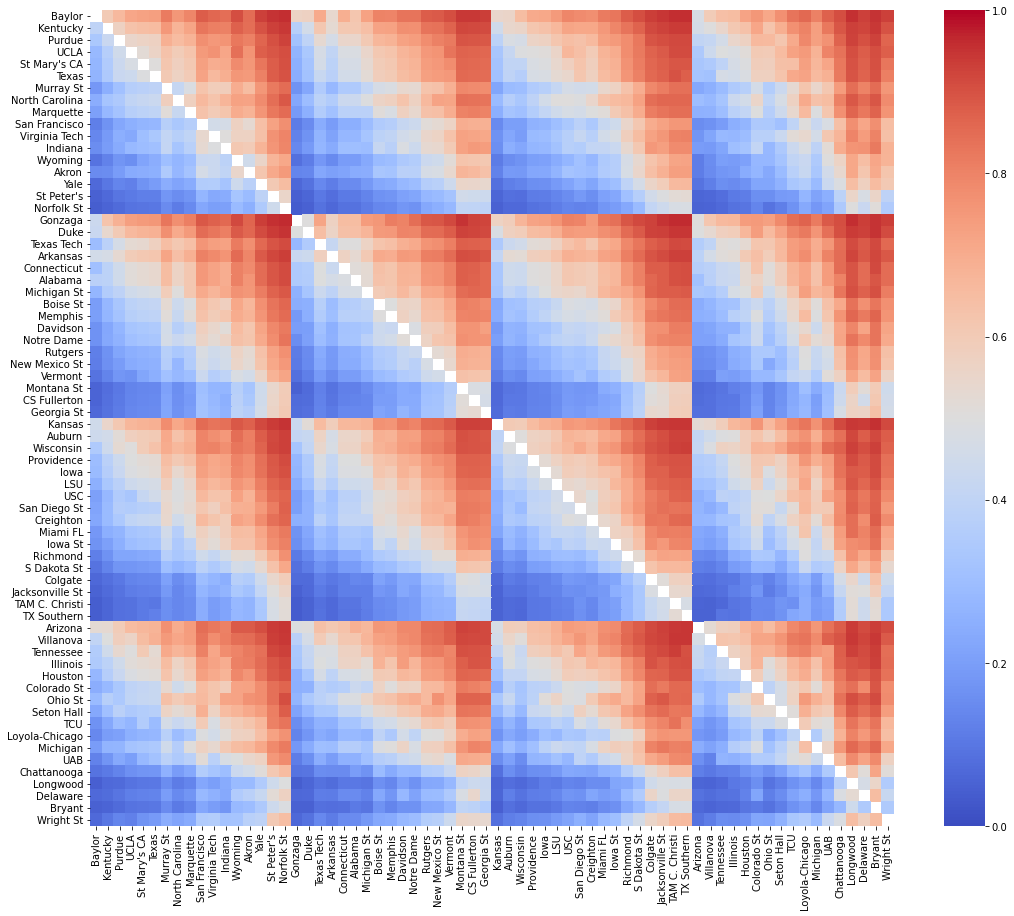

In [228]:
plot_heatmap('reg_pred.csv', 2022)

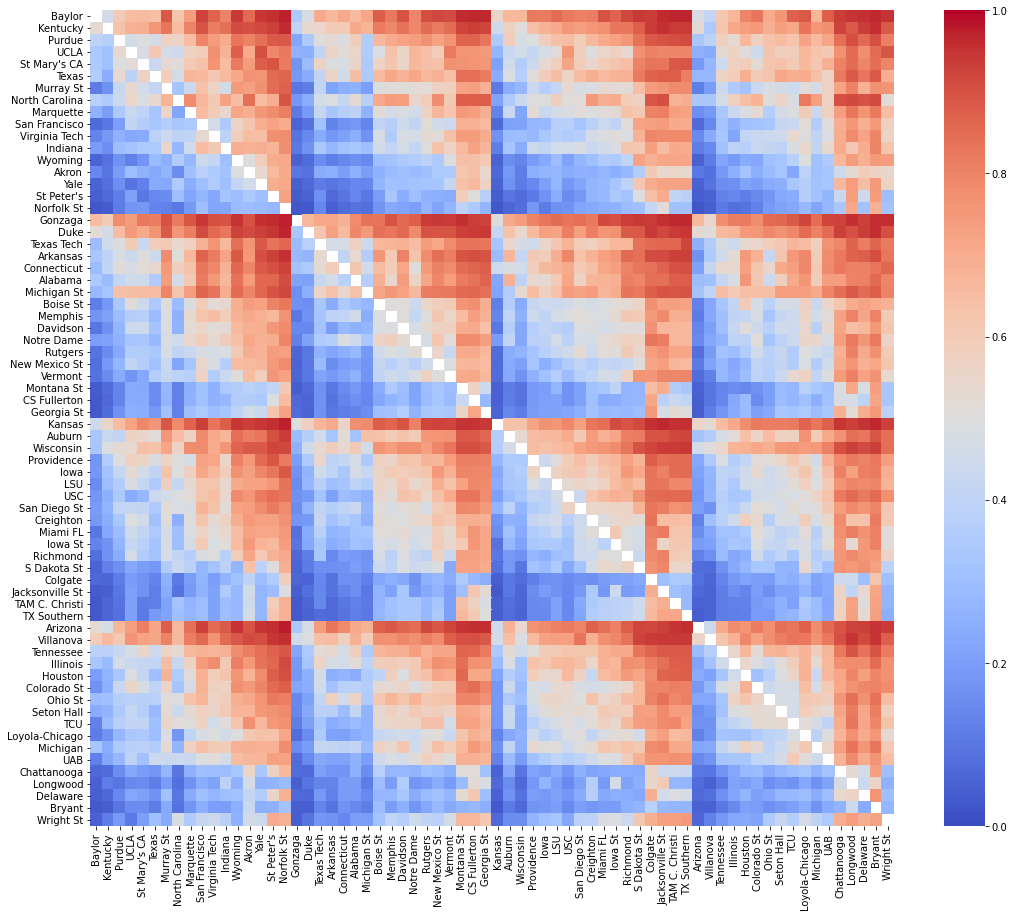

In [229]:
plot_heatmap('cat_pred.csv', 2022)

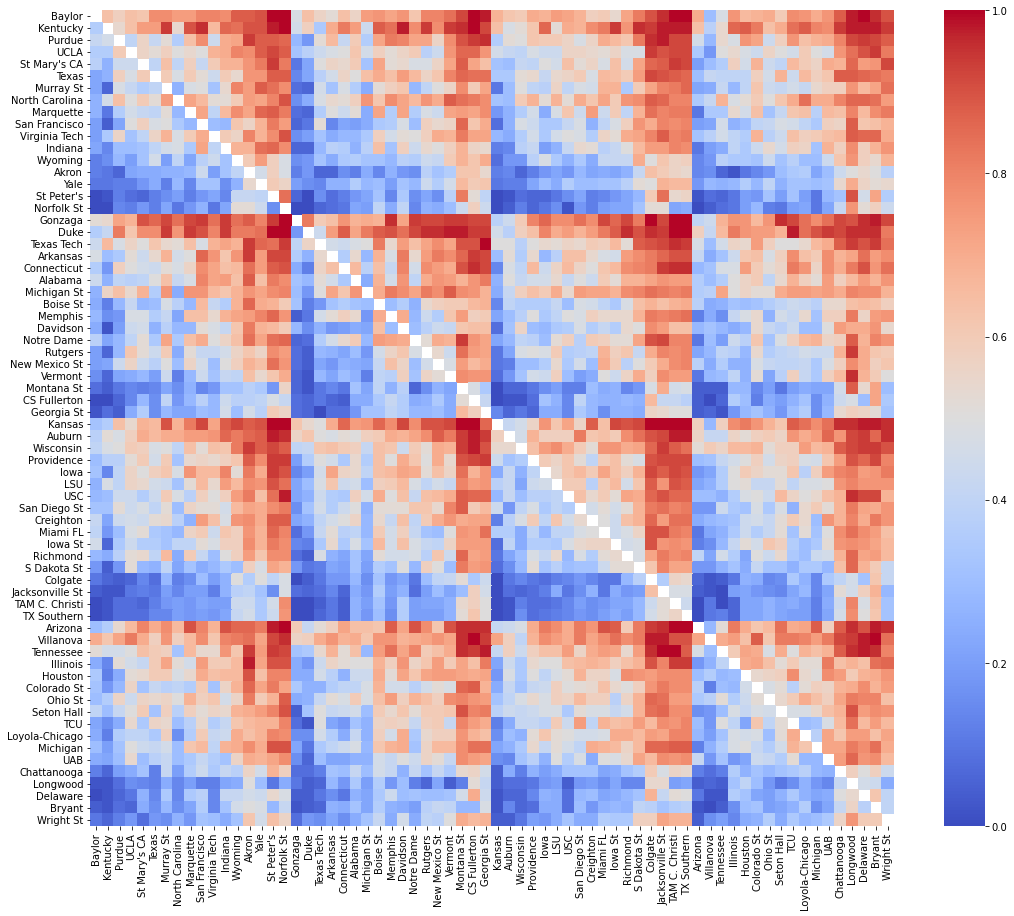

In [230]:
plot_heatmap('rf_pred.csv', 2022)

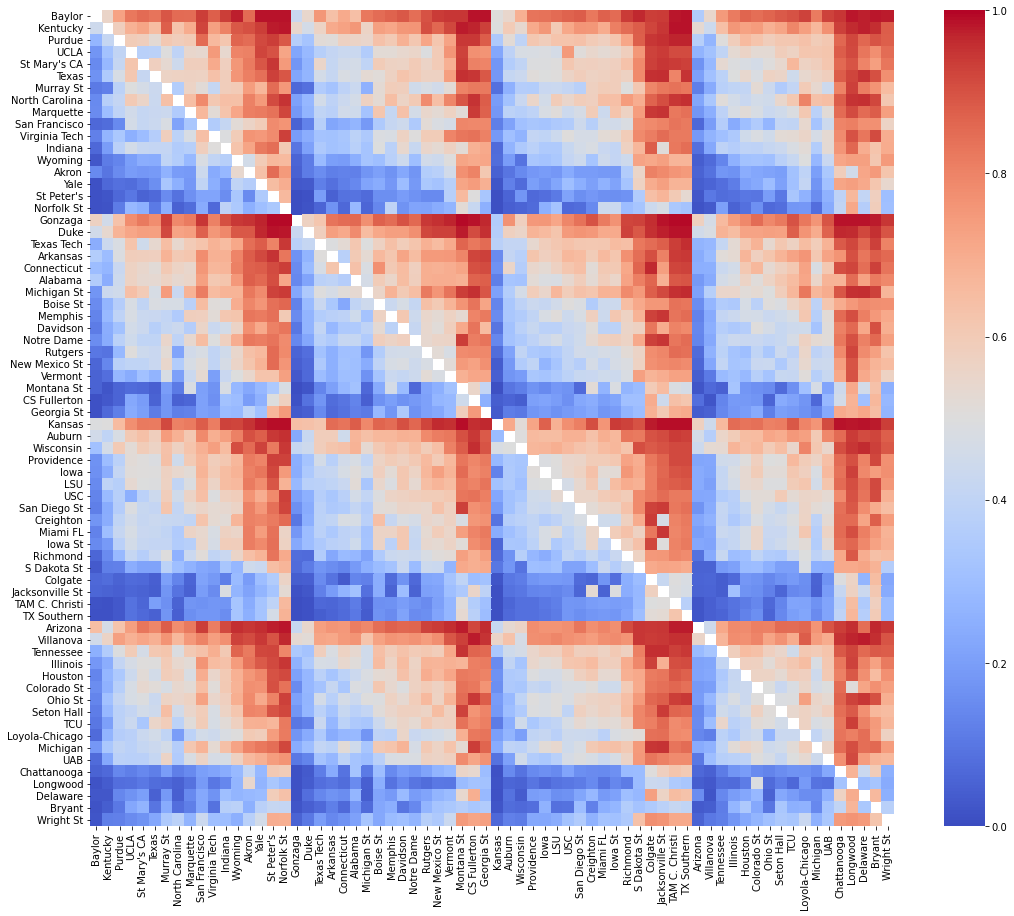

In [231]:
plot_heatmap('xgb_pred.csv', 2022)